<a href="https://colab.research.google.com/github/MarcosAutuori/My_Fastai_Book_FastAi_Course/blob/master/07_sizing_and_tta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.1 MB/s eta 0:00:00
Mounted at /content/gdriv

In [ ]:
#hide
from fastbook import *

# Training a State-of-the-Art Model

This chapter introduces more advanced techniques for training an image classification model and getting state-of-the-art results. You can skip it if you want to learn more about other applications of deep learning and come back to it later—knowledge of this material will not be assumed in later chapters.

We will look at what normalization is, a powerful data augmentation technique called mixup, the progressive resizing approach and test time augmentation. To show all of this, we are going to train a model from scratch (not using transfer learning) using a subset of ImageNet called [Imagenette](https://github.com/fastai/imagenette). It contains a subset of 10 very different categories from the original ImageNet dataset, making for quicker training when we want to experiment.

This is going to be much harder to do well than with our previous datasets because we're using full-size, full-color images, which are photos of objects of different sizes, in different orientations, in different lighting, and so forth. So, in this chapter we're going to introduce some important techniques for getting the most out of your dataset, especially when you're training from scratch, or using transfer learning to train a model on a very different kind of dataset than the pretrained model used.

## Imagenette

When fast.ai first started there were three main datasets that people used for building and testing computer vision models:

- ImageNet:: 1.3 million images of various sizes around 500 pixels across, in 1,000 categories, which took a few days to train
- MNIST:: 50,000 28×28-pixel grayscale handwritten digits
- CIFAR10:: 60,000 32×32-pixel color images in 10 classes

The problem was that the smaller datasets didn't actually generalize effectively to the large ImageNet dataset. The approaches that worked well on ImageNet generally had to be developed and trained on ImageNet. This led to many people believing that only researchers with access to giant computing resources could effectively contribute to developing image classification algorithms.

We thought that seemed very unlikely to be true. We had never actually seen a study that showed that ImageNet happen to be exactly the right size, and that other datasets could not be developed which would provide useful insights. So we thought we would try to create a new dataset that researchers could test their algorithms on quickly and cheaply, but which would also provide insights likely to work on the full ImageNet dataset.

About three hours later we had created Imagenette. We selected 10 classes from the full ImageNet that looked very different from one another. As we had hoped, we were able to quickly and cheaply create a classifier capable of recognizing these classes. We then tried out a few algorithmic tweaks to see how they impacted Imagenette. We found some that worked pretty well, and tested them on ImageNet as well—and we were very pleased to find that our tweaks worked well on ImageNet too!

There is an important message here: the dataset you get given is not necessarily the dataset you want. It's particularly unlikely to be the dataset that you want to do your development and prototyping in. You should aim to have an iteration speed of no more than a couple of minutes—that is, when you come up with a new idea you want to try out, you should be able to train a model and see how it goes within a couple of minutes. If it's taking longer to do an experiment, think about how you could cut down your dataset, or simplify your model, to improve your experimentation speed. The more experiments you can do, the better!

Let's get started with this dataset:

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

First we'll get our dataset into a `DataLoaders` object, using the *presizing* trick introduced in <<chapter_pet_breeds>>:

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

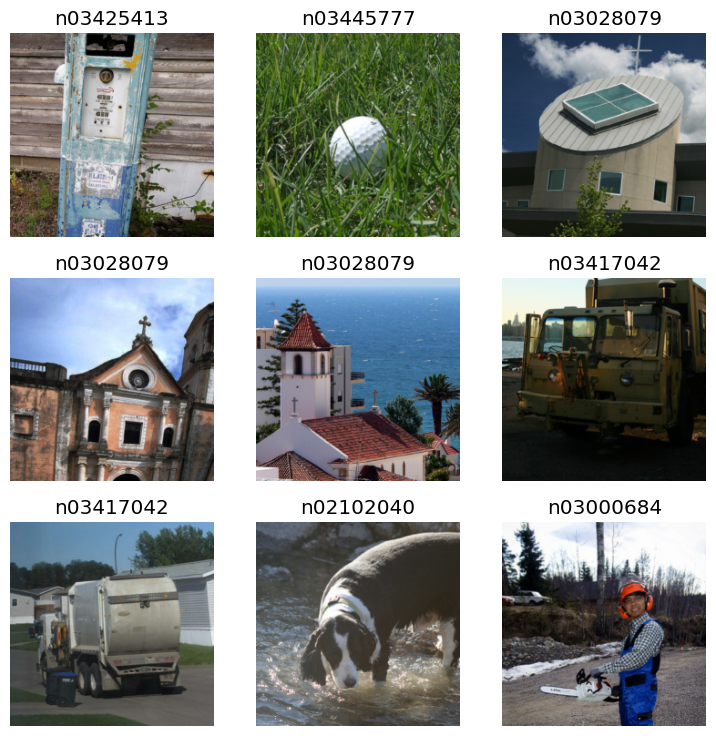

In [ ]:
dls.show_batch(max_n=9)

and do a training run that will serve as a baseline:

In [ ]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.583403,2.064317,0.401792,01:03
1,1.208877,1.260106,0.601568,01:02
2,0.925265,1.036154,0.664302,01:03
3,0.730190,0.700906,0.777819,01:03
4,0.585707,0.541810,0.825243,01:03


That's a good baseline, since we are not using a pretrained model, but we can do better. When working with models that are being trained from scratch, or fine-tuned to a very different dataset than the one used for the pretraining, there are some additional techniques that are really important. In the rest of the chapter we'll consider some of the key approaches you'll want to be familiar with. The first one is *normalizing* your data.

## Normalization

When training a model, it helps if your input data is normalized—that is, has a mean of 0 and a standard deviation of 1. But most images and computer vision libraries use values between 0 and 255 for pixels, or between 0 and 1; in either case, your data is not going to have a mean of 0 and a standard deviation of 1.

Let's grab a batch of our data and look at those values, by averaging over all axes except for the channel axis, which is axis 1:

In [ ]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 3, 224, 224])

In [ ]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4770, 0.4855, 0.4672]), TensorImage([0.2933, 0.2759, 0.2942]))

As we expected, the mean and standard deviation are not very close to the desired values. Fortunately, normalizing the data is easy to do in fastai by adding the `Normalize` transform. This acts on a whole mini-batch at once, so you can add it to the `batch_tfms` section of your data block. You need to pass to this transform the mean and standard deviation that you want to use; fastai comes with the standard ImageNet mean and standard deviation already defined. (If you do not pass any statistics to the `Normalize` transform, fastai will automatically calculate them from a single batch of your data.)

Let's add this transform (using `imagenet_stats` as Imagenette is a subset of ImageNet) and take a look at one batch now:

In [ ]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [ ]:
dls = get_dls(64, 224)

In [ ]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0559,  0.0862,  0.2298]),
 TensorImage([1.2117, 1.2150, 1.3092]))

Let's check what effect this had on training our model:

In [ ]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.632865,2.250024,0.391337,01:02
1,1.294041,1.579932,0.517177,01:02
2,0.960535,1.069164,0.657207,01:04
3,0.730220,0.767433,0.771845,01:05
4,0.577889,0.550673,0.824496,01:06


Although it only helped a little here, normalization becomes especially important when using pretrained models. The pretrained model only knows how to work with data of the type that it has seen before. If the average pixel value was 0 in the data it was trained with, but your data has 0 as the minimum possible value of a pixel, then the model is going to be seeing something very different to what is intended!

This means that when you distribute a model, you need to also distribute the statistics used for normalization, since anyone using it for inference, or transfer learning, will need to use the same statistics. By the same token, if you're using a model that someone else has trained, make sure you find out what normalization statistics they used, and match them.

We didn't have to handle normalization in previous chapters because when using a pretrained model through `vision_learner`, the fastai library automatically adds the proper `Normalize` transform; the model has been pretrained with certain statistics in `Normalize` (usually coming from the ImageNet dataset), so the library can fill those in for you. Note that this only applies with pretrained models, which is why we need to add this information manually here, when training from scratch.

All our training up until now has been done at size 224. We could have begun training at a smaller size before going to that. This is called *progressive resizing*.

## Progressive Resizing

When fast.ai and its team of students [won the DAWNBench competition](https://www.theverge.com/2018/5/7/17316010/fast-ai-speed-test-stanford-dawnbench-google-intel) in 2018, one of the most important innovations was something very simple: start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher. We call this approach *progressive resizing*.

> jargon: progressive resizing: Gradually using larger and larger images as you train.

As we have seen, the kinds of features that are learned by convolutional neural networks are not in any way specific to the size of the image—early layers find things like edges and gradients, and later layers may find things like noses and sunsets. So, when we change image size in the middle of training, it doesn't mean that we have to find totally different parameters for our model.

But clearly there are some differences between small images and big ones, so we shouldn't expect our model to continue working exactly as well, with no changes at all. Does this remind you of something? When we developed this idea, it reminded us of transfer learning! We are trying to get our model to learn to do something a little bit different from what it has learned to do before. Therefore, we should be able to use the `fine_tune` method after we resize our images.

There is an additional benefit to progressive resizing: it is another form of data augmentation. Therefore, you should expect to see better generalization of your models that are trained with progressive resizing.

To implement progressive resizing it is most convenient if you first create a `get_dls` function which takes an image size and a batch size as we did in the section before, and returns your `DataLoaders`:

Now you can create your `DataLoaders` with a small size and use `fit_one_cycle` in the usual way, training for a few less epochs than you might otherwise do:

In [ ]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(),
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.902943,2.447006,0.401419,00:30
1,1.315203,1.572992,0.525765,00:30
2,1.001199,0.767886,0.759149,00:30
3,0.765864,0.665562,0.797984,00:30


Then you can replace the `DataLoaders` inside the `Learner`, and fine-tune:

In [ ]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.985213,1.654063,0.565721,01:06


epoch,train_loss,valid_loss,accuracy,time
0,0.706869,0.689622,0.784541,01:07
1,0.739217,0.928541,0.712472,01:07
2,0.629462,0.788906,0.764003,01:07
3,0.491912,0.502622,0.836445,01:06
4,0.414880,0.431332,0.863331,01:06


As you can see, we're getting much better performance, and the initial training on small images was much faster on each epoch.

You can repeat the process of increasing size and training more epochs as many times as you like, for as big an image as you wish—but of course, you will not get any benefit by using an image size larger than the size of your images on disk.

Note that for transfer learning, progressive resizing may actually hurt performance. This is most likely to happen if your pretrained model was quite similar to your transfer learning task and dataset and was trained on similar-sized images, so the weights don't need to be changed much. In that case, training on smaller images may damage the pretrained weights.

On the other hand, if the transfer learning task is going to use images that are of different sizes, shapes, or styles than those used in the pretraining task, progressive resizing will probably help. As always, the answer to "Will it help?" is "Try it!"

Another thing we could try is applying data augmentation to the validation set. Up until now, we have only applied it on the training set; the validation set always gets the same images. But maybe we could try to make predictions for a few augmented versions of the validation set and average them. We'll consider this approach next.

## Test Time Augmentation

We have been using random cropping as a way to get some useful data augmentation, which leads to better generalization, and results in a need for less training data. When we use random cropping, fastai will automatically use center cropping for the validation set—that is, it will select the largest square area it can in the center of the image, without going past the image's edges.

This can often be problematic. For instance, in a multi-label dataset sometimes there are small objects toward the edges of an image; these could be entirely cropped out by center cropping. Even for problems such as our pet breed classification example, it's possible that some critical feature necessary for identifying the correct breed, such as the color of the nose, could be cropped out.

One solution to this problem is to avoid random cropping entirely. Instead, we could simply squish or stretch the rectangular images to fit into a square space. But then we miss out on a very useful data augmentation, and we also make the image recognition more difficult for our model, because it has to learn how to recognize squished and squeezed images, rather than just correctly proportioned images.

Another solution is to not just center crop for validation, but instead to select a number of areas to crop from the original rectangular image, pass each of them through our model, and take the maximum or average of the predictions. In fact, we could do this not just for different crops, but for different values across all of our test time augmentation parameters. This is known as *test time augmentation* (TTA).

> jargon: test time augmentation (TTA): During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

Depending on the dataset, test time augmentation can result in dramatic improvements in accuracy. It does not change the time required to train at all, but will increase the amount of time required for validation or inference by the number of test-time-augmented images requested. By default, fastai will use the unaugmented center crop image plus four randomly augmented images.

You can pass any `DataLoader` to fastai's `tta` method; by default, it will use your validation set:

In [ ]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8737863898277283

As we can see, using TTA gives us good a boost in performance, with no additional training required. However, it does make inference slower—if you're averaging five images for TTA, inference will be five times slower.

We've seen examples of how data augmentation helps train better models. Let's now focus on a new data augmentation technique called *Mixup*.

## Mixup

Mixup, introduced in the 2017 paper ["*mixup*: Beyond Empirical Risk Minimization"](https://arxiv.org/abs/1710.09412) by Hongyi Zhang et al., is a very powerful data augmentation technique that can provide dramatically higher accuracy, especially when you don't have much data and don't have a pretrained model that was trained on data similar to your dataset. The paper explains: "While data augmentation consistently leads to improved generalization, the procedure is dataset-dependent, and thus requires the use of expert knowledge." For instance, it's common to flip images as part of data augmentation, but should you flip only horizontally, or also vertically? The answer is that it depends on your dataset. In addition, if flipping (for instance) doesn't provide enough data augmentation for you, you can't "flip more." It's helpful to have data augmentation techniques where you can "dial up" or "dial down" the amount of change, to see what works best for you.

Mixup works as follows, for each image:

1. Select another image from your dataset at random.
1. Pick a weight at random.
1. Take a weighted average (using the weight from step 2) of the selected image with your image; this will be your independent variable.
1. Take a weighted average (with the same weight) of this image's labels with your image's labels; this will be your dependent variable.

In pseudocode, we're doing this (where `t` is the weight for our weighted average):

```
image2,target2 = dataset[randint(0,len(dataset)]
t = random_float(0.5,1.0)
new_image = t * image1 + (1-t) * image2
new_target = t * target1 + (1-t) * target2
```

For this to work, our targets need to be one-hot encoded. The paper describes this using the equations shown in <<mixup>> where $\lambda$ is the same as `t` in our pseudocode:

<img src="https://github.com/fastai/fastbook/blob/master/images/att_00063.png?raw=1" caption="An excerpt from the Mixup paper" alt="An excerpt from the Mixup paper" width="700" id="mixup">

### Sidebar: Papers and Math

We're going to be looking at more and more research papers from here on in the book. Now that you have the basic jargon, you might be surprised to discover how much of them you can understand, with a little practice! One issue you'll notice is that Greek letters, such as $\lambda$, appear in most papers. It's a very good idea to learn the names of all the Greek letters, since otherwise it's very hard to read the papers to yourself, and remember them (or to read code based on them, since code often uses the names of the Greek letters spelled out, such as `lambda`).

The bigger issue with papers is that they use math, instead of code, to explain what's going on. If you don't have much of a math background, this will likely be intimidating and confusing at first. But remember: what is being shown in the math, is something that will be implemented in code. It's just another way of talking about the same thing! After reading a few papers, you'll pick up more and more of the notation. If you don't know what a symbol is, try looking it up in Wikipedia's [list of mathematical symbols](https://en.wikipedia.org/wiki/List_of_mathematical_symbols) or drawing it in [Detexify](http://detexify.kirelabs.org/classify.html), which (using machine learning!) will find the name of your hand-drawn symbol. Then you can search online for that name to find out what it's for.

### End sidebar

<<mixup_example>> shows what it looks like when we take a *linear combination* of images, as done in Mixup.

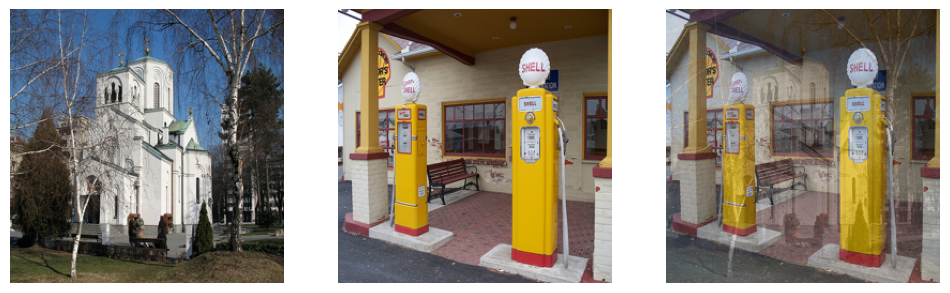

In [ ]:
#hide_input
#id mixup_example
#caption Mixing a church and a gas station
#alt An image of a church, a gas station and the two mixed up.
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

The third image is built by adding 0.3 times the first one and 0.7 times the second. In this example, should the model predict "church" or "gas station"? The right answer is 30% church and 70% gas station, since that's what we'll get if we take the linear combination of the one-hot-encoded targets. For instance, suppose we have 10 classes and "church" is represented by the index 2 and "gas station" is represented by the index 7, the one-hot-encoded representations are:
```
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] and [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
```
so our final target is:
```
[0, 0, 0.3, 0, 0, 0, 0, 0.7, 0, 0]
```

This all done for us inside fastai by adding a *callback* to our `Learner`. `Callback`s are what is used inside fastai to inject custom behavior in the training loop (like a learning rate schedule, or training in mixed precision). We'll be learning all about callbacks, including how to make your own, in <<chapter_accel_sgd>>. For now, all you need to know is that you use the `cbs` parameter to `Learner` to pass callbacks.

Here is how we train a model with Mixup:

```python
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5, 3e-3)
```

What happens when we train a model with data that's "mixed up" in this way? Clearly, it's going to be harder to train, because it's harder to see what's in each image. And the model has to predict two labels per image, rather than just one, as well as figuring out how much each one is weighted. Overfitting seems less likely to be a problem, however, because we're not showing the same image in each epoch, but are instead showing a random combination of two images.

Mixup requires far more epochs to train to get better accuracy, compared to other augmentation approaches we've seen. You can try training Imagenette with and without Mixup by using the *examples/train_imagenette.py* script in the [fastai repo](https://github.com/fastai/fastai). At the time of writing, the leaderboard in the [Imagenette repo](https://github.com/fastai/imagenette/) is showing that Mixup is used for all leading results for trainings of >80 epochs, and for fewer epochs Mixup is not being used. This is in line with our experience of using Mixup too.

One of the reasons that Mixup is so exciting is that it can be applied to types of data other than photos. In fact, some people have even shown good results by using Mixup on activations *inside* their models, not just on inputs—this allows Mixup to be used for NLP and other data types too.

There's another subtle issue that Mixup deals with for us, which is that it's not actually possible with the models we've seen before for our loss to ever be perfect. The problem is that our labels are 1s and 0s, but the outputs of softmax and sigmoid can never equal 1 or 0. This means training our model pushes our activations ever closer to those values, such that the more epochs we do, the more extreme our activations become.

With Mixup we no longer have that problem, because our labels will only be exactly 1 or 0 if we happen to "mix" with another image of the same class. The rest of the time our labels will be a linear combination, such as the 0.7 and 0.3 we got in the church and gas station example earlier.

One issue with this, however, is that Mixup is "accidentally" making the labels bigger than 0, or smaller than 1. That is to say, we're not *explicitly* telling our model that we want to change the labels in this way. So, if we want to make the labels closer to, or further away from 0 and 1, we have to change the amount of Mixup—which also changes the amount of data augmentation, which might not be what we want. There is, however, a way to handle this more directly, which is to use *label smoothing*.

## Label Smoothing

In the theoretical expression of loss, in classification problems, our targets are one-hot encoded (in practice we tend to avoid doing this to save memory, but what we compute is the same loss as if we had used one-hot encoding). That means the model is trained to return 0 for all categories but one, for which it is trained to return 1. Even 0.999 is not "good enough", the model will get gradients and learn to predict activations with even higher confidence. This encourages overfitting and gives you at inference time a model that is not going to give meaningful probabilities: it will always say 1 for the predicted category even if it's not too sure, just because it was trained this way.

This can become very harmful if your data is not perfectly labeled. In the bear classifier we studied in <<chapter_production>>, we saw that some of the images were mislabeled, or contained two different kinds of bears. In general, your data will never be perfect. Even if the labels were manually produced by humans, they could make mistakes, or have differences of opinions on images that are harder to label.

Instead, we could replace all our 1s with a number a bit less than 1, and our 0s by a number a bit more than 0, and then train. This is called *label smoothing*. By encouraging your model to be less confident, label smoothing will make your training more robust, even if there is mislabeled data. The result will be a model that generalizes better.

This is how label smoothing works in practice: we start with one-hot-encoded labels, then replace all 0s with $\frac{\epsilon}{N}$ (that's the Greek letter *epsilon*, which is what was used in the [paper that introduced label smoothing](https://arxiv.org/abs/1512.00567) and is used in the fastai code), where $N$ is the number of classes and $\epsilon$ is a parameter (usually 0.1, which would mean we are 10% unsure of our labels). Since we want the labels to add up to 1, replace the 1 by $1-\epsilon + \frac{\epsilon}{N}$. This way, we don't encourage the model to predict something overconfidently. In our Imagenette example where we have 10 classes, the targets become something like (here for a target that corresponds to the index 3):
```
[0.01, 0.01, 0.01, 0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
```
In practice, we don't want to one-hot encode the labels, and fortunately we won't need to (the one-hot encoding is just good to explain what label smoothing is and visualize it).

### Sidebar: Label Smoothing, the Paper

Here is how the reasoning behind label smoothing was explained in the paper by Christian Szegedy et al.:

> : This maximum is not achievable for finite $z_k$ but is approached if $z_y\gg z_k$ for all $k\neq y$—that is, if the logit corresponding to the ground-truth label is much great than all other logits. This, however, can cause two problems. First, it may result in over-fitting: if the model learns to assign full probability to the ground-truth label for each training example, it is not guaranteed to generalize. Second, it encourages the differences between the largest logit and all others to become large, and this, combined with the bounded gradient $\frac{\partial\ell}{\partial z_k}$, reduces the ability of the model to adapt. Intuitively, this happens because the model becomes too confident about its predictions.

Let's practice our paper-reading skills to try to interpret this. "This maximum" is refering to the previous part of the paragraph, which talked about the fact that 1 is the value of the label for the positive class. So it's not possible for any value (except infinity) to result in 1 after sigmoid or softmax. In a paper, you won't normally see "any value" written; instead it will get a symbol, which in this case is $z_k$. This shorthand is helpful in a paper, because it can be referred to again later and the reader will know what value is being discussed.

Then it says "if $z_y\gg z_k$ for all $k\neq y$." In this case, the paper immediately follows the math with an English description, which is handy because you can just read that. In the math, the $y$ is refering to the target ($y$ is defined earlier in the paper; sometimes it's hard to find where symbols are defined, but nearly all papers will define all their symbols somewhere), and $z_y$ is the activation corresponding to the target. So to get close to 1, this activation needs to be much higher than all the others for that prediction.

Next, consider the statement "if the model learns to assign full probability to the ground-truth label for each training example, it is not guaranteed to generalize." This is saying that making $z_y$ really big means we'll need large weights and large activations throughout our model. Large weights lead to "bumpy" functions, where a small change in input results in a big change to predictions. This is really bad for generalization, because it means just one pixel changing a bit could change our prediction entirely!

Finally, we have "it encourages the differences between the largest logit and all others to become large, and this, combined with the bounded gradient $\frac{\partial\ell}{\partial z_k}$, reduces the ability of the model to adapt." The gradient of cross-entropy, remember, is basically `output - target`. Both `output` and `target` are between 0 and 1, so the difference is between `-1` and `1`, which is why the paper says the gradient is "bounded" (it can't be infinite). Therefore our SGD steps are bounded too. "Reduces the ability of the model to adapt" means that it is hard for it to be updated in a transfer learning setting. This follows because the difference in loss due to incorrect predictions is unbounded, but we can only take a limited step each time.

### End sidebar

To use this in practice, we just have to change the loss function in our call to `Learner`:

```python
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)
```

Like with Mixup, you won't generally see significant improvements from label smoothing until you train more epochs. Try it yourself and see: how many epochs do you have to train before label smoothing shows an improvement?

## Conclusion

You have now seen everything you need to train a state-of-the-art model in computer vision, whether from scratch or using transfer learning. Now all you have to do is experiment on your own problems! See if training longer with Mixup and/or label smoothing avoids overfitting and gives you better results. Try progressive resizing, and test time augmentation.

Most importantly, remember that if your dataset is big, there is no point prototyping on the whole thing. Find a small subset that is representative of the whole, like we did with Imagenette, and experiment on it.

In the next three chapters, we will look at the other applications directly supported by fastai: collaborative filtering, tabular modeling and working with text. We will go back to computer vision in the next section of the book, with a deep dive into convolutional neural networks in _chapter_convolutions_.

## Questionnaire

1. What is the difference between ImageNet and Imagenette? When is it better to experiment on one versus the other?
1. What is normalization?
1. Why didn't we have to care about normalization when using a pretrained model?
1. What is progressive resizing?
1. Implement progressive resizing in your own project. Did it help?
1. What is test time augmentation? How do you use it in fastai?
1. Is using TTA at inference slower or faster than regular inference? Why?
1. What is Mixup? How do you use it in fastai?
1. Why does Mixup prevent the model from being too confident?
1. Why does training with Mixup for five epochs end up worse than training without Mixup?
1. What is the idea behind label smoothing?
1. What problems in your data can label smoothing help with?
1. When using label smoothing with five categories, what is the target associated with the index 1?
1. What is the first step to take when you want to prototype quick experiments on a new dataset?

### Further Research

1. Use the fastai documentation to build a function that crops an image to a square in each of the four corners, then implement a TTA method that averages the predictions on a center crop and those four crops. Did it help? Is it better than the TTA method of fastai?
1. Find the Mixup paper on arXiv and read it. Pick one or two more recent articles introducing variants of Mixup and read them, then try to implement them on your problem.
1. Find the script training Imagenette using Mixup and use it as an example to build a script for a long training on your own project. Execute it and see if it helps.
1. Read the sidebar "Label Smoothing, the Paper", look at the relevant section of the original paper and see if you can follow it. Don't be afraid to ask for help!